#### Import libraries

In [1]:
import pandas as pd

#### Scrape data from Wikipedia page

In [2]:
#using pandas
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikitable = pd.read_html(url)
df = wikitable[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [3]:
#ignore cells with a borough that is Not assigned
df = df[df.Borough!='Not assigned']
df.reset_index(inplace=True, drop = True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [4]:
#check if any rows in Neighbourhood meets the condition above
chk = df['Neighbourhood'].str.contains('Not assigned') 
chk.value_counts()

False    103
Name: Neighbourhood, dtype: int64

#### Result: All of the Borough rows have assigned Neighbourhood

#### Number of rows of in the dataframe

In [5]:
df.shape

(103, 3)

### Add Latitude and Longitude Coordinate

#### Download dataset

In [148]:
#!wget -O Geospatial_Coordinates.csv https://cocl.us/Geospatial_data

In [6]:
coord_df = pd.read_csv('Geospatial_Coordinates.csv')
coord_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merging the Dataframes

In [7]:
df = df.merge(coord_df, left_on='Postal Code', right_on='Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Visualization and Clustering

#### 1. Generate the map

#### Import libraries

In [8]:
import numpy as np
import json #library to handle JSON files

#!conda install -c conda-forge geopy --yes #uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim #convert an address into latitude and longitude values

import requests #library to handle requests
from pandas.io.json import json_normalize #tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes #uncomment this line if you haven't completed the Foursquare API lab
import folium #map rendering library

#### Create a dataframe with only boroughs that contain the word Toronto

In [32]:
toronto_data = df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


#### Get latitude and longitude values of Toronto

In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with marker

In [42]:
#create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

#add markers to map
for lat, lng, postcode, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Postal Code'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}, {}'.format(postcode, borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### 2. Use Foursquare API to get venues in the neighbourhoods

#### Define Foursquare Credentials and Version

In [147]:
CLIENT_ID = '' #your Foursquare ID
CLIENT_SECRET = '' #your Foursquare Secret
VERSION = '20180605' #Foursquare API version
LIMIT = 100 #A default Foursquare API limit value

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Explore the first neighborhood in the dataframe and get the latitude and longitude values

In [35]:
toronto_data.loc[0,'Neighbourhood']

'Regent Park, Harbourfront'

In [36]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] #neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] #neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighbourhood'] #neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


#### Get the top 100 venues that are in Regent Park within a radius of 500 meters

##### Create the GET request URL

In [146]:
LIMIT = 100 #limit of number of venues returned by Foursquare API
radius = 500 #define radius

#create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url #display URL

##### Send GET request

In [39]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fc920de76cc650db816229f'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 44,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

##### Define a function to extract the venue's category and name

In [40]:
#function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

##### Clean the JSON and build it as a dataframe

In [43]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) #flatten JSON

#filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

#filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

#clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Impact Kitchen,Restaurant,43.656369,-79.356980


In [44]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

44 venues were returned by Foursquare.


#### 3. Explore the neighbourhoods in Toronto

#### Define a function to extract the venue's category and name in all the neighborhoods in Toronto

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        #create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        #make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the function and create a new dataframe

In [47]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
toronto_venues.head()

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


#### Check how many venues were returned for each neighbourhood

In [48]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


#### Check how many unique categories were returned

In [49]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


#### 4. Analyze each neighbourhood

In [50]:
#one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

#move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine the size

In [52]:
toronto_onehot.shape

(1624, 236)

#### Group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [53]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.014706
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,0.000000,...,0.013333,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.026667
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.030000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


Examine the new size

In [54]:
toronto_grouped.shape

(39, 236)

#### Print each neighbourhood along with the top 5 most common venues

In [55]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1     Cheese Shop  0.04
2      Restaurant  0.04
3          Bakery  0.04
4  Farmers Market  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1       Nightclub  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4             Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
           venue  freq
0           Park  0.06
1  Auto Workshop  0.06
2        Brewery  0.06
3     Skate Park  0.06
4  Burrito Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2             Plane  0.06
3   Harbor / Marina  0.06
4  Sculpture Garden  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1                Café  0.06
2      Sandwich Pl

#### Put the result into a pandas dataframe

##### Define a function to sort the venues in descending order

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Create the new dataframe and display the top 10 venues for each neighbourhood

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Cocktail Bar,Beer Bar,Cheese Shop,Seafood Restaurant,Restaurant,Farmers Market,Sandwich Place,Breakfast Spot
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Climbing Gym,Burrito Place,Restaurant,Italian Restaurant,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Skate Park,Pizza Place,Brewery,Burrito Place,Restaurant,Farmers Market,Fast Food Restaurant,Butcher,Recording Studio,Auto Workshop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Harbor / Marina,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Coffee Shop,Plane
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Bubble Tea Shop,Salad Place,Burger Joint,Department Store,Thai Restaurant


#### 5. Cluster neighbourhoods

##### Run K-means to cluster the neighbourhoods

In [135]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

##### Determine the optimal value of K in K-Means Clustering

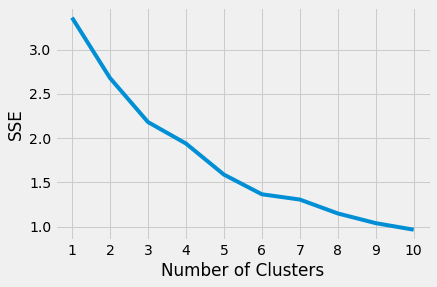

The optimal value of K is 5 .


In [138]:
#!conda install -c conda-forge kneed --yes 
from kneed import KneeLocator
import matplotlib.pyplot as plt

#store the sse value for each K
sse =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, random_state=0) 
    KM.fit(toronto_grouped_clustering) 
    sse.append(KM.inertia_)      

#plot the sse against K values
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters") 
plt.ylabel("SSE") 
plt.show() 

#identify the elbow point
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print('The optimal value of K is {} .'.format(kl.elbow))

Run K-means Clustering again with the optimal value of K

##### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood

In [136]:
# reset the cluster labels
del neighbourhoods_venues_sorted['Cluster Labels']

# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Pub,Café,Theater,Breakfast Spot,Event Space,Shoe Store,Hotel
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Diner,Lingerie Store,Ramen Restaurant,Italian Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Trail,Health Food Store,Neighborhood,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


##### Visualize the clusters using a map

In [139]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 6. Examine Clusters

##### Cluster 1

In [140]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Bus Line,Swim School,Colombian Restaurant,Dessert Shop,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
21,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307,0,Park,Sushi Restaurant,Jewelry Store,Trail,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
33,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Park,Trail,Playground,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


#### Based on the common venues, let's call this cluster "Outdoor Cluster"

##### Cluster 2

In [141]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.38316,1,Trail,Playground,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


#### Based on the common venues, let's call this cluster "Trail Cluster"

##### Cluster 3

In [142]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Pub,Café,Theater,Breakfast Spot,Event Space,Shoe Store,Hotel
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Diner,Lingerie Store,Ramen Restaurant,Italian Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Coffee Shop,Bakery,Cocktail Bar,Beer Bar,Cheese Shop,Seafood Restaurant,Restaurant,Farmers Market,Sandwich Place,Breakfast Spot
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Japanese Restaurant,Bubble Tea Shop,Salad Place,Burger Joint,Department Store,Thai Restaurant
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Nightclub,Baby Store,Coffee Shop,Athletics & Sports,Restaurant
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,Coffee Shop,Café,Gym,Restaurant,Hotel,Thai Restaurant,Bar,Clothing Store,Cosmetics Shop,Concert Hall
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Pharmacy,Bakery,Grocery Store,Brewery,Bank,Middle Eastern Restaurant,Bar,Café,Supermarket,Music Venue
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,2,Coffee Shop,Aquarium,Café,Hotel,Scenic Lookout,Fried Chicken Joint,Restaurant,Pizza Place,Brewery,Bar


#### Based on the common venues, let's call this cluster "Food Cluster"

##### Cluster 4

In [144]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Trail,Health Food Store,Neighborhood,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


#### Based on the common venues, let's call this cluster "Pub Cluster"

##### Cluster 5

In [145]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[list(range(0, toronto_merged.shape[1]))]]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,Central Toronto,Roselawn,43.711695,-79.416936,4,Music Venue,Garden,Yoga Studio,Department Store,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


#### Based on the common venues, let's call this cluster "Entertainment Cluster"